In [1]:
import CodaPCA
import CodaCl 
import PCACl
import numpy as np
from runpca import read_csv
import os
import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#change module for newer sklearn versions
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import dill
import importlib
importlib.reload(CodaCl)

<module 'CodaCl' from 'C:\\Users\\u5801283\\Documents\\Honours\\honours_final\\honours\\Code\\coda-pca-orig\\coda\\codes\\CodaCl.py'>

In [2]:
def enhanced_cross_val(features, targets, folds):
    assert len(features) == len(targets), "Mismatch in length of features and targets"
    kfold_scores = []
    for train, test in folds:
        Y_train = targets[train]
        X_train = features[train]
               
        Y_test = targets[test]
        X_test = features[test]
                
        model = LogisticRegression(multi_class='auto', solver='lbfgs')
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        kfold_scores.append(sklearn.metrics.accuracy_score(Y_test,y_pred))
                
    return kfold_scores

#can automate this if we had assume a certain structure for the indices of features and targets, or an array per dataset 




In [3]:
def coda_val(features, targets, n_components, folds, nn_shape,  lr,lam, epochs):
    kfold_scores = []
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        
        model = CodaCl.CoDA_Cl(50, n_components, 4, nn_shape[0], nn_shape[1])


        val_arr, train_arr = model.fit(X_train, Y_train, lam, lr, train_size = int(len(X_train)*(3/4)), epochs=epochs)
        
        print ("Plot!")
        
        plt.plot(val_arr, c="red")
        plt.plot(train_arr, c="blue")
        
        plt.ylim(bottom=min(train_arr))

        plt.show()
        
        pred = model.predict(torch.FloatTensor(X_test))
        
        pred = pred.exp().detach()     
        _, index = torch.max(pred,1)  
        pred = pred.numpy()
        index = index.numpy()
        
        kfold_scores.append(sklearn.metrics.accuracy_score(Y_test,index))
                
    return kfold_scores


In [14]:
def PCA_Classification(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=True):
       #can loop through/optimise this in another way?
    
    features = np.array(data[:,co_feature_indices],dtype=np.float32)
    
    features_ = features
    
    targets = data[:,target_index]
    
    le = LabelEncoder()
    le.fit(targets)
    targets = le.transform(targets)
    #set up as int list, and subtract to get index so NLL loss works
#     targets = list(map(int,data[:,0]))
#     targets = [target - 1 for target in targets]

    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    extra_features = data[:,other_feature_indices]
    
    #TODO double check this
    features = np.hstack([features, extra_features])
    

    n_components=5
#     print(features)

    
# #     pca_coda = CodaPCA.NonParametricCodaPCA(n_components)
# #     Y_coda = pca_coda.fit_transform(np.array(features, dtype=np.float32))

# #     pca_clr = CodaPCA.CLRPCA(n_components)
# #     Y_clr = pca_clr.fit_transform(np.array(features, dtype=np.float32))
    
    
    
#     sc = StandardScaler()
#     features_ = sc.fit_transform(np.array(features, dtype=np.float32))

#     pca_reg = decomposition.PCA(n_components)

#     pca_reg.fit(features_)
#     Y_pca = pca_reg.transform(features_)
  

    splits = 4
    #split data 
    kf = KFold(splits)
        
    folds = [i for i in kf.split(features)] 

#     coda_score = enhanced_cross_val(Y_coda, np.array(targets), folds)
#     clr_score = enhanced_cross_val(Y_clr, np.array(targets), folds) 
#    naive_score = enhanced_cross_val(Y_pca, np.array(targets), folds)

#     import itertools
#     nn_vals = [[[5,], [2,]]]#, [[10,],[5,]], [[10,5], [3,5]], [[50,], [20,]], [[50,20], [10,20]]]
#     lr_vals = [1e-3]#, 1e-3, 5e-4,1e-4 ]
#     lam_vals = [1e-12]#1e-12,5e-12,1e-11,5e-11,1e-10,5e-10,1e-5,1e-4,0.001,0.1,1,10,100]
#     epoch_vals = [5000]

#     param_list = list(itertools.product(*[nn_vals, lr_vals, lam_vals, epoch_vals]))
# #     param_file = open("paramresultswineclass.txt","w") 
# #     param_file.write("Results from hyperparameter grid search:\n\n") 

#     param_dict = {}
        
#     for params in param_list:
#         nn_shape = params[0]
#         lr = params[1]
#         lam = params[2]
#         n_epochs = params[3]

#         score = coda_val(features, np.array(targets), 2, folds, nn_shape, lr, lam, n_epochs )

#         param_dict[tuple([sum(nn_shape[0]) + sum(nn_shape[1]), lr, lam, n_epochs])] = np.mean(score)
#         param_file.write("nn {}, lr {}, lam {}, epochs {}, num_samples {}, num_features {} \nScore: {} \nMean_score: {} \n\n".format(nn_shape, lr, lam, n_epochs, len(features), len(co_feature_indices), score, np.mean(score)))

#         param_file.close()

    #codacl_score = coda_val(features, np.array(targets), n_components, folds)

    nn_shape = [[20,], [20,]]
    lr = 1e-3
    lam = 1e-4
    n_epochs = 1000

    codacl_score = coda_val(np.array(features,dtype=np.float32), np.array(targets), 10, folds, nn_shape, lr, lam, n_epochs )
    
    if verbose:
#         print("CoDA-PCA:")
#         print(coda_score)
#         print("CLR-PCA:")
#         print(clr_score)
#         print ("Naive Classification:")
#         print (naive_score)
        print ("Coda Cl:")
        print (codacl_score)

    return codacl_score#coda_score,clr_score,naive_score,codacl_score


In [5]:
# wine = pd.read_csv("wine.data", header=None)

# data = wine.to_numpy()
# np.random.shuffle(data)


In [6]:
# %matplotlib inline
# param_dict = PCA_Classification(np.array(data), [1,2,3,4,5,6,7,8,9,10,11,12,13], 0)

# with open('param_search.pik', 'wb') as f:
#     dill.dump(param_dict, f)


In [7]:
# file = open('param_search.pik','rb')

# c = dill.load(file)

In [8]:
#PCA_Classification(np.array(data), [1,2,3,4,5,6,7,8,9,10,11,12,13], 0)



In [9]:
import pandas as pd
import numpy as np
rug_data = pd.read_hdf('rug.h5','rug')


#cut off data below certain threshold
n_features = 50

#go an extra 2 for the targets
data = rug_data[rug_data.columns[:n_features]].join(rug_data[rug_data.columns[-2]]).to_numpy()
np.random.shuffle(data)
data.shape


(282, 51)

In [10]:
#remove space added to some of the targets
for i in range(0, len(data[:,-2])):
    if data[:,-1][i] == 'Luing ':
        data[:,-1][i] = 'Luing'
    if data[:,-1][i] == 'Aax':
        data[:,-1][i] = 'AAx'
data[:,-1]


array(['Luing', 'LIMx', 'Luing', 'AAx', 'AAx', 'Luing', 'AAx', 'LIMx',
       'LIMx', 'AAx', 'CHx', 'LIMx', 'CHx', 'AAx', 'LIMx', 'CHx', 'Luing',
       'CHx', 'CHx', 'LIMx', 'AAx', 'Luing', 'AAx', 'LIMx', 'AAx',
       'Luing', 'LIMx', 'LIMx', 'AAx', 'Luing', 'AAx', 'AAx', 'CHx',
       'LIMx', 'CHx', 'LIMx', 'LIMx', 'CHx', 'Luing', 'Luing', 'LIMx',
       'Luing', 'CHx', 'LIMx', 'LIMx', 'AAx', 'LIMx', 'CHx', 'CHx',
       'LIMx', 'AAx', 'Luing', 'LIMx', 'AAx', 'Luing', 'Luing', 'Luing',
       'Luing', 'AAx', 'AAx', 'LIMx', 'Luing', 'Luing', 'CHx', 'CHx',
       'Luing', 'Luing', 'Luing', 'LIMx', 'AAx', 'LIMx', 'LIMx', 'LIMx',
       'Luing', 'CHx', 'AAx', 'LIMx', 'Luing', 'AAx', 'Luing', 'Luing',
       'LIMx', 'CHx', 'CHx', 'CHx', 'CHx', 'CHx', 'LIMx', 'AAx', 'LIMx',
       'LIMx', 'AAx', 'AAx', 'Luing', 'CHx', 'CHx', 'CHx', 'CHx', 'AAx',
       'AAx', 'Luing', 'Luing', 'LIMx', 'CHx', 'CHx', 'AAx', 'LIMx',
       'Luing', 'Luing', 'CHx', 'AAx', 'CHx', 'Luing', 'Luing', 'LIMx',
    

loading
Plot!


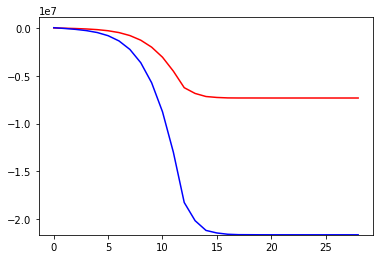

loading
Plot!


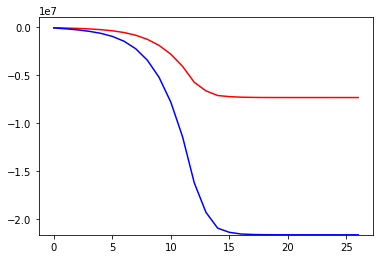

loading
Plot!


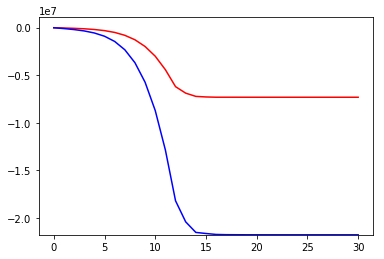

loading
Plot!


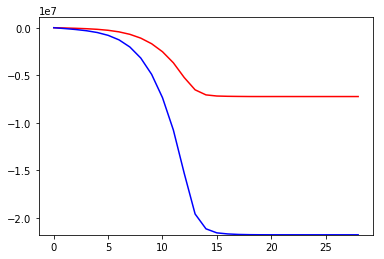

Coda Cl:
[0.18309859154929578, 0.2676056338028169, 0.21428571428571427, 0.2714285714285714]


[0.18309859154929578,
 0.2676056338028169,
 0.21428571428571427,
 0.2714285714285714]

In [15]:
%matplotlib inline
PCA_Classification(np.array(data), np.arange(50), -1)

In [12]:
#redo experiments reducing the number of features

#order features by the total sum 

rug_data

,0,1,2,3,4,5,6,7,8,9,...,4933,4934,4935,4936,4937,4938,4939,4940,BREED,Age slaughter
10572_0001,3.06965,3.93829,0.27041,2.02871,0.148492,3.05138,0.438748,0.651761,3.40698,0.365337,...,0.00956366,0.279789,0.0114144,0.0218691,0.00669643,0.00874638,0.00834762,0.0089022,Luing,637
10572_0002,18.5756,0.699453,0.334538,2.05406,1.35362,0.614154,4.75996,4.58927,21.5137,1.72205,...,0.0120013,0.034126,0.00738234,0.0110093,0.00460641,0.00587583,0.0060364,0.010275,Luing,621
10572_0003,1.79319,0.553815,0.0686969,1.54644,0.925597,0.443305,0.125548,0.465388,1.80804,0.092782,...,0.0103018,0.0645859,0.721732,0.013341,0.00521601,0.00770882,0.00706621,0.00942008,CHx,589
10572_0005,10.3565,0.044952,2.43033,5.86313,22.0809,0.035694,150.994,19.044,8.55842,73.7565,...,0.00623347,0.0125656,0.0059835,0.00535399,0.00426087,0.00471237,0.00646622,0.0187846,Luing,636
10572_0006,37.2827,5.18618,1.39753,8.73003,0.561768,4.26773,3.65911,9.46495,51.6763,4.56902,...,0.00599716,0.00770077,0.00425647,0.0281229,0.00577445,0.00517324,0.00496826,0.00532036,CHx,574
10572_0007,28.8569,0.0322147,0.267366,4.55587,11.809,0.0302703,161.112,4.65229,27.4059,87.2209,...,0.0109727,0.00387345,0.00608009,0.0116289,0.00430968,0.0037694,0.00398243,0.0151425,CHx,626
10572_0008,4.85365,9.6704,0.919455,6.88828,22.035,10.9049,24.783,6.46426,3.43006,48.5025,...,0.00580666,0.00683161,0.00675004,0.0492058,0.00419921,0.00509489,0.00442841,0.0668509,Luing,635
10572_0009,0.865806,14.5823,0.0890674,1.50776,4.6192,11.6059,0.916365,1.72996,0.763039,0.557735,...,0.0179136,0.0159538,0.0130543,0.126278,0.00854323,0.013821,0.0127018,0.012817,Luing,647
10572_0010,4.4502,3.35784,0.187926,3.00358,0.894089,2.66468,1.79262,0.964823,4.88527,2.74243,...,0.0115634,0.0999092,0.0112384,0.0188954,0.00789603,0.0114717,0.0107309,0.012216,CHx,640
10572_0011,13.2733,0.101337,52.8284,15.7434,5.09065,1.62934,0.541677,13.1563,10.1943,0.580662,...,0.0103481,0.0124555,0.00682801,0.0191544,0.00563261,0.00720387,0.00740927,0.0200259,CHx,571


In [13]:
le = LabelEncoder()
le.fit(targets)
le.classes_

NameError: name 'targets' is not defined

In [ ]:
encoded_targets = le.transform(targets)

In [ ]:
type(features[0][0])

In [ ]:
features = np.array([feat/sum(feat) for feat in features])

pca_coda = CodaPCA.NonParametricCodaPCA(2)
pca_coda.fit(features.astype(float))



    
Y_coda = pca_coda.transform(features.astype(float))

In [ ]:
%matplotlib inline
plt.scatter(Y_coda[:,0], Y_coda[:,1], c=encoded_targets)


In [ ]:
features = np.array([feat/sum(feat) for feat in features])

pca_coda = CodaPCA.CLRPCA(3)
pca_coda.fit(features.astype(float))



    
Y_clr = pca_coda.transform(features.astype(float))

%matplotlib inline
plt.scatter(Y_clr[:,0], Y_clr[:,1], c=encoded_targets)

In [ ]:
import sklearn.decomposition
sc = StandardScaler()
features_ = sc.fit_transform(features.astype(float))

pca_reg = decomposition.PCA(3)
Y_pca = pca_reg.fit_transform(features_)

In [ ]:
%matplotlib inline
plt.scatter(Y_pca[:,0], Y_pca[:,1], c=encoded_targets)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = Y_coda[:,0], ys = Y_coda[:,1], zs = Y_coda[:,2],c =encoded_targets)

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = Y_clr[:,0], ys = Y_clr[:,1], zs = Y_clr[:,2],c =encoded_targets)


ax.view_init(10, 90)
plt.draw()